## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import codecs
from collections import Counter

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
print(len(nltk_data))

3914


In [5]:
nltk_data_words, nltk_data_tags = [], []
nltk_data_words_set, nltk_data_tags_set = set(), set()
for sent in nltk_data:
    for tup in sent:
        nltk_data_words.append(tup[0])
        nltk_data_tags.append(tup[1])
        nltk_data_words_set.add(tup[0])
        nltk_data_tags_set.add(tup[1])
print(len(nltk_data_words))
print(len(nltk_data_tags))                           

100676
100676


In [6]:
print(len(nltk_data_words_set))
print(len(nltk_data_tags_set))

12408
12


In [7]:
print(nltk_data_tags_set)

{'X', 'PRT', 'DET', 'NOUN', 'ADV', '.', 'CONJ', 'VERB', 'ADJ', 'NUM', 'ADP', 'PRON'}


In [8]:
# Splitting train and test as 95% and 5%
random.seed(100)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

In [9]:
print(len(train_set))
print(len(test_set))

3718
196


In [10]:
# Obtaining list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95722

In [11]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Sales',
 'by',
 'these',
 'subsidiaries',
 'in',
 'the',
 'fiscal',
 'year',
 'ending',
 'last']

In [12]:
# vocabulary
V = set(tokens)
print(len(V))

12079


In [13]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [14]:
print(T)

{'X', 'PRT', 'DET', 'NOUN', 'ADV', '.', 'CONJ', 'VERB', 'ADJ', 'NUM', 'ADP', 'PRON'}


### Emission Probabilities

In [15]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [16]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [17]:
tags_df

,X,PRT,DET,NOUN,ADV,.,CONJ,VERB,ADJ,NUM,ADP,PRON
X,0.074492,0.186785,0.054797,0.061468,0.025413,0.164390,0.010483,0.203621,0.017471,0.002859,0.141995,0.056226
PRT,0.012638,0.001944,0.101102,0.244005,0.010045,0.043746,0.002268,0.403435,0.085224,0.058004,0.019443,0.018146
DET,0.045394,0.000241,0.005554,0.638295,0.012677,0.017626,0.000483,0.039961,0.204153,0.022456,0.009538,0.003622
NOUN,0.029225,0.044129,0.013046,0.264412,0.016908,0.239378,0.042745,0.146892,0.012098,0.009475,0.177064,0.004628
ADV,0.023333,0.014000,0.068667,0.031667,0.078000,0.136667,0.006667,0.344667,0.129333,0.031667,0.119667,0.015667
.,0.026811,0.002429,0.172919,0.223032,0.052722,0.093207,0.058030,0.087719,0.043365,0.081152,0.092398,0.066127
CONJ,0.008821,0.005107,0.118384,0.355153,0.053389,0.033890,0.000464,0.155525,0.116063,0.040854,0.052461,0.059889
VERB,0.218372,0.031318,0.134574,0.109767,0.081550,0.034729,0.005426,0.169380,0.065736,0.022946,0.090543,0.035659
ADJ,0.021438,0.011049,0.005112,0.699538,0.004617,0.063489,0.016821,0.011873,0.065963,0.020943,0.078661,0.000495
NUM,0.209968,0.027426,0.003244,0.352993,0.002949,0.117370,0.013270,0.018284,0.032439,0.184901,0.035683,0.001474


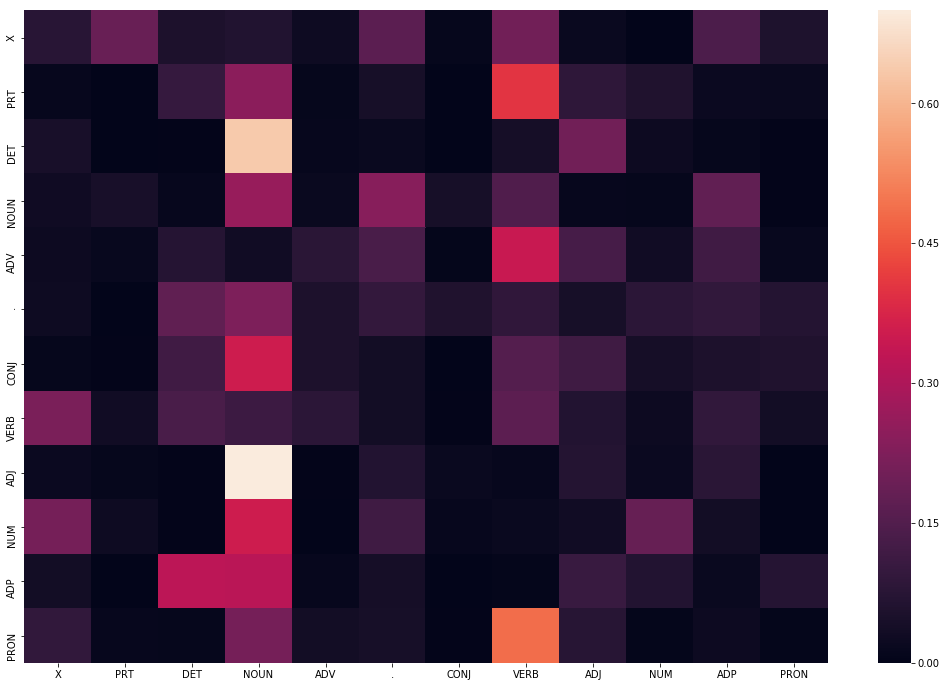

In [18]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

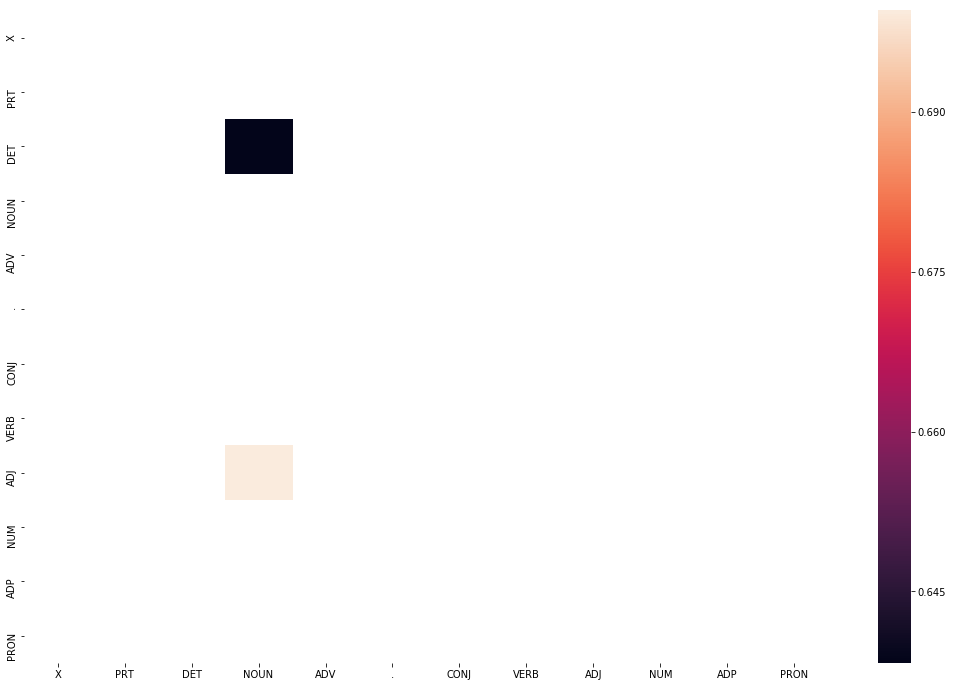

In [19]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [20]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # Obtaining state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


### Test Evaluation

In [21]:
# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [22]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [23]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  703.2087814807892
[('The', 'DET'), ('October', 'NOUN'), ('survey', 'NOUN'), ('of', 'ADP'), ('corporate', 'ADJ'), ('purchasing', 'NOUN'), ('managers', 'NOUN'), (',', '.'), ('as', 'ADP'), ('*', 'X'), ('expected', 'VERB'), (',', '.'), ('provided', 'VERB'), ('evidence', 'NOUN'), ('that', 'ADP'), ('economic', 'ADJ'), ('growth', 'NOUN'), ('remains', 'VERB'), ('subdued', 'VERB'), ('.', '.'), ('Municipal', 'NOUN'), ('bonds', 'NOUN'), ('were', 'VERB'), ('mostly', 'ADV'), ('unchanged', 'ADJ'), ('to', 'PRT'), ('up', 'ADV'), ('1\\/8', 'NUM'), ('point', 'NOUN'), ('in', 'ADP'), ('light', 'ADJ'), (',', '.'), ('cautious', 'ADJ'), ('trading', 'NOUN'), ('prior', 'ADV'), ('to', 'PRT'), ('tomorrow', 'NOUN'), ("'s", 'PRT'), ('unemployment', 'NOUN'), ('report', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('addition', 'NOUN'), (',', '.'), ('the', 'DET'), ('company', 'NOUN'), ('has', 'VERB'), ('replaced', 'VERB'), ('its', 'PRON'), ('president', 'NOUN'), ('and', 'CONJ'), ('chief', 'NOUN'), ('ex

In [24]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9099717400080742


In [25]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [26]:
incorrect_tagged_cases

[[('corporate', 'ADJ'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [('.', '.'), (('Municipal', 'NOUN'), ('Municipal', 'ADJ'))],
 [('companies', 'NOUN'), (('bankroll', 'X'), ('bankroll', 'VERB'))],
 [('with', 'ADP'), (('promising', 'X'), ('promising', 'ADJ'))],
 [('The', 'DET'), (('senior', 'ADJ'), ('senior', 'NOUN'))],
 [('is', 'VERB'), (('Nigel', 'X'), ('Nigel', 'NOUN'))],
 [('Nigel', 'NOUN'), (('Judah', 'X'), ('Judah', 'NOUN'))],
 [('.', '.'), (('ORTEGA', 'X'), ('ORTEGA', 'NOUN'))],
 [('ORTEGA', 'NOUN'), (('ENDED', 'X'), ('ENDED', 'VERB'))],
 [('the', 'DET'), (('mid-1970s', 'X'), ('mid-1970s', 'NUM'))],
 [('company', 'NOUN'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('already', 'ADV'), (('own', 'ADJ'), ('own', 'VERB'))],
 [('.', '.'), (('Shortly', 'X'), ('Shortly', 'ADV'))],
 [('Shortly', 'ADV'), (('afterwards', 'X'), ('afterwards', 'ADV'))],
 [('of', 'ADP'), (('anti-China', 'X'), ('anti-China', 'ADJ'))],
 [('anti-China', 'ADJ'), (('sanctions', 'VERB'), ('sanctions', 'NOUN'))]

In [27]:
#Obtain the count of all tags in the training set
tag_counts = Counter(pair[1] for pair in train_tagged_words)
tag_counts

Counter({'NOUN': 27442,
         'ADP': 9378,
         'DET': 8283,
         'ADJ': 6064,
         'VERB': 12900,
         '.': 11115,
         'NUM': 3391,
         'X': 6296,
         'CONJ': 2154,
         'ADV': 3000,
         'PRON': 2613,
         'PRT': 3086})

In [28]:
#Load the test sentences with unknown words
sentences=[]
f = codecs.open("Test_sentences.txt", encoding='utf-8')
for s in f:
    print(s)
    sentences.append(s)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

In [29]:
#Strip the special characters and empty strings in the list file
test_sentences =[sent.rstrip() for sent in sentences if sent.rstrip()!='']
test_sentences

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [30]:
#Predict using Vanilla Viterbi
sample_pred_list =[]
for line in test_sentences:
    sample_pred_list=sample_pred_list+list(Viterbi(word_tokenize(line)))
sample_pred_list

[('Android', 'X'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'X'),
 ('.', '.'),
 ('Android', 'X'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'X'),
 ('worldwide', 'X'),
 ('on', 'ADP'),
 ('smartphones', 'X'),
 ('since', 'ADP'),
 ('2011', 'X'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'X'),
 ('.', '.'),
 ('Google', 'X'),
 ('and', 'CONJ'),
 ('Twitter', 'X'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'X'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'X'),
 ("'s", 'PRT'),
 ('firehose', 'X'),
 ('.', '.'),
 ('Twitter', 'X'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'X'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 

In [31]:
#Obtains tokens in the test file
sample_words=[tokens for line in test_sentences for tokens in word_tokenize(line)]
#Obtain list of words present in test sentences but not in the training corpus
words_not_in_corpus = list(set(sample_words) - set(tokens))
words_not_in_corpus

['21st',
 'worldwide',
 '2015',
 'firehose',
 'ICESAT-2',
 'OS',
 'trips',
 '2013',
 'tweets',
 'tournament',
 'smartphones',
 'online',
 'domineering',
 'NASA',
 'Twitter',
 '2018',
 '2011',
 'Satellite',
 'FIFA',
 'contested',
 'messages',
 'Google',
 'Android',
 'Cup',
 'interact',
 'personality',
 'arriving',
 'invited']

In [32]:
#Obtain the tags predicted for unknown words
[tup for tup in sample_pred_list for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'X'),
 ('Google', 'X'),
 ('Android', 'X'),
 ('OS', 'X'),
 ('worldwide', 'X'),
 ('smartphones', 'X'),
 ('2011', 'X'),
 ('2013', 'X'),
 ('Google', 'X'),
 ('Twitter', 'X'),
 ('2015', 'X'),
 ('Google', 'X'),
 ('Twitter', 'X'),
 ('firehose', 'X'),
 ('Twitter', 'X'),
 ('online', 'X'),
 ('interact', 'X'),
 ('messages', 'X'),
 ('tweets', 'X'),
 ('domineering', 'X'),
 ('personality', 'X'),
 ('2018', 'X'),
 ('FIFA', 'X'),
 ('Cup', 'X'),
 ('21st', 'X'),
 ('FIFA', 'X'),
 ('Cup', 'X'),
 ('tournament', 'X'),
 ('contested', 'X'),
 ('Cup', 'X'),
 ('trips', 'X'),
 ('arriving', 'X'),
 ('NASA', 'X'),
 ('invited', 'X'),
 ('ICESAT-2', 'X'),
 ('Satellite', 'X')]

In [33]:
#Obtain the count of incorrectly classfied words for each tag
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'NOUN': 27,
         'X': 309,
         'ADJ': 39,
         'ADV': 16,
         'VERB': 20,
         'DET': 8,
         'PRT': 4,
         'ADP': 22,
         'NUM': 1})

### Solve the problem of unknown words

#### Approaches for tagging unknown words

- Lexicon based
Improve the vocabulary with another lexicon which has sentences tagged. However the problem of uknown words would still exist, especially if the lexicon used was in vogue few years ago, and the unknown test data has current day slang or words relevant recently. Therefore this approach will not be of much use.

- Rule based
- Probability based

#### Laplace Smoothing - Probability based model 1

1. Laplace smoothing

Since the emission probability will be 0 if the word never occurs in the training corpus. This can be offset by using Laplace smoothing which ensures non-zero probability for both emission and transition probabilities and results in a prediction that is slightly improved.

q(s|u,v) = (c(u,v,s)+lambda)/(c(u,v)+lambda*v)
e(x|s) = (c(s->x)+lambda)/(c(s)+lambda*v)



In [34]:
def t2_given_t1_laplace(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
#Taking lambda = 0.5 for laplace smoothing
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]+0.5/(t2_given_t1(t2, t1)[1]+(0.5*len(V)))

# convert the matrix to a df for better readability
tags_df_laplace = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [35]:
# Viterbi Heuristic
def Viterbi_Laplace(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df_laplace.loc['.', tag]
            else:
                transition_p = tags_df_laplace.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]+0.5/(word_given_tag(words[key], tag)[1]+(0.5*len(V)))
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # Obtaining state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm - 1 With Laplace smoothing

In [36]:
start = time.time()
tagged_seq = Viterbi_Laplace(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  715.2716059684753


In [37]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9170367379895035


As we can see a minor improvement of accuracy after laplace smoothening, which is non trivial. However we find that we have only eliminated non zero probability. The probability of unknown words still exist to some degree. Since we are looking for further improvements specifically around predicting unknown words, we can try out rule based taggers next 

#### Rule based model - A lexicon tagger with a rule based backup

Few of the common rules we are aware of and can implement are as follows
Ending in ed - Verb
Ending in ing - Verb gerund or commonly Verb
Adjective is followed by a noun
Adverb is followed by a verb
Determinant is followed by mostly a proper noun but we can generalize this to a noun
If all else fails we can to some degree say the word is a Noun since it usually is the most occurring POS in our corpus as well as the most tagged predicted inaccurately.

In [38]:
# Obtain the % of verbs which are classifed as 'verb which end with 'ed'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:5]

0.2058139534883721


[('fired', 'VERB'),
 ('committed', 'VERB'),
 ('discussed', 'VERB'),
 ('characterized', 'VERB'),
 ('learned', 'VERB')]

In [39]:
# Obtain the % of verbs which are classifed as 'verb which end with 'ing'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(verbs))
ing_verbs[:5]

0.1082170542635659


[('ending', 'VERB'),
 ('making', 'VERB'),
 ('controlling', 'VERB'),
 ('leaving', 'VERB'),
 ('reviewing', 'VERB')]

In [40]:
#Obtain % of Adjective tags followed by nouns
# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of Adj tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_noun_tags))
print(len(adj_noun_tags) / len(adj_tags))

6064
4242
0.6995382585751979


In [41]:
#Obtain % of Determinent tags followed by nouns
dt_tags = [t for t in tags if t == 'DET']
dt_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_noun_tags))
print(len(dt_noun_tags) / len(dt_tags))

8283
5287
0.638295303633949


In [42]:
#Obtain % of Adverbs tags followed by Verbs
adv_tags = [t for t in tags if t == 'ADV']
adv_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(adv_tags))
print(len(adv_vb_tags))
print(len(adv_vb_tags) / len(adv_tags))

3000
1034
0.3446666666666667


In [43]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [44]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)
lexicon_tagger.evaluate(test_set)

0.9438837303189342

#### Evaluating tagging accuracy

In [45]:
#Trigram tagger backed by Bigram backed by Unigram which is backed by rule based tagger
t0 = nltk.RegexpTagger(patterns)
t1 = nltk.UnigramTagger(train_set, backoff=t0)
t2 = nltk.BigramTagger(train_set, backoff=t1)
t3 = nltk.TrigramTagger(train_set, backoff=t2)

In [46]:
#Import libraries for brill
import nltk.tag
from nltk.tag import brill
from nltk.tag.brill import *
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer

#Clear existing templates if any
Template._cleartemplates()

#Load the fntbl37 template
templates = fntbl37()
 
#Train the Brill model
trainer = BrillTaggerTrainer(t3, templates)
brill_tagger = trainer.train(train_set, max_rules=100, min_score=3)

If we use laplace transformed viterbi it would be difficult to map the cases of uknown words since we have offset by a non zero probabilility for these cases.

Therefore we will consider the rule based tagger without laplace transformation. The viterbi algorithm is to be modified such that when  state_probability is zero, then pmax will be zero. In such situations we can use the brill modelled with bigram, unigram and rule based backup to obtain a state_max. 

In [47]:
# Viterbi Heuristic
def Viterbi_RuleBased(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # Obtaining state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm - 2 Rule based tagger.

In [48]:
# tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_RuleBased(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

702.8513686656952


In [49]:
# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.9477190149374243

#### Modified rule based tagger - 2 

We find that even for tags where probability is not zero but close to zero there is a good chance that the predictions are inaccurate. Therefore instead of using zero probability for pmax - we can check for low values of pmax and use our Brill tagger with rule based backup instead. This could provide a good improvement to not just unknown tag prediction but also to tags inaccurately predicted.

In [53]:
# Viterbi Heuristic
def Viterbi_RuleBased2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is close to zero
        if(pmax<0.001):
            #If state probability is very small if the word is unknown or does not have good probabilistic predictions
            # we can utilizethe brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # Obtaining state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm - 3 Rule based 2nd model

In [105]:
# tagging the test sentences with the updated Viterbi algorith - Cannot run the whole test due to it taking close to 6 hours
# list of tagged words
test_run_base_sample = [tup for sent in test_set[100] for tup in sent]

# list of untagged words
test_tagged_words_sample = [tup[0] for sent in test_run_base_sample for tup in sent]

start = time.time()
updated_tagged_seq = Viterbi_RuleBased2(test_tagged_words_sample)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

36.517091274261475


In [106]:
# Calculate the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_tagged_words_sample) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.0

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [79]:
# print the test sentences with the initial Viterbi algorithm
vanilla_viterbi = []
for line in test_sentences:
    vanilla_viterbi.append(list(Viterbi(word_tokenize(line))))
print(vanilla_viterbi)

[[('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.')], [('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'X'), ('.', '.')], [('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.')], [('Twitter', 'X'), ('is', 'VERB'), ('an', 'DET'), ('online', 'X'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('

In [127]:
def Diff(li1, li2): 
    li_diff = []
    list1 = [item for sublist in li1 for item in sublist]
    list2 = [item for sublist in li2 for item in sublist]
    for i in list1 : 
        for j in list2:
            if (i[0]==j[0] and i[1]!=j[1]):
                li_diff.append((i[0],i[1],j[1]))
    return set(li_diff) 

In [128]:
# print the test sentences with the laplace modified Viterbi algorithm
laplace_viterbi = []
for line in test_sentences:
    laplace_viterbi.append(list(Viterbi_Laplace(word_tokenize(line))))
Diff(laplace_viterbi,vanilla_viterbi)

{('2011', 'DET', 'X'),
 ('2013', 'DET', 'X'),
 ('2015', 'DET', 'X'),
 ('2018', 'NOUN', 'X'),
 ('21st', 'NOUN', 'X'),
 ('Android', 'DET', 'X'),
 ('Cup', '.', 'X'),
 ('FIFA', '.', 'X'),
 ('Google', 'DET', 'X'),
 ('ICESAT-2', 'DET', 'X'),
 ('NASA', 'DET', 'X'),
 ('OS', 'NOUN', 'X'),
 ('Satellite', 'NOUN', 'X'),
 ('Twitter', '.', 'X'),
 ('Twitter', 'DET', 'X'),
 ('Twitter', 'VERB', 'X'),
 ('and', 'NOUN', 'CONJ'),
 ('arriving', 'NOUN', 'X'),
 ('contested', 'DET', 'X'),
 ('domineering', 'NOUN', 'X'),
 ('firehose', 'VERB', 'X'),
 ('interact', 'NOUN', 'X'),
 ('invited', 'NOUN', 'X'),
 ('messages', 'DET', 'X'),
 ('online', 'NOUN', 'X'),
 ('personality', '.', 'X'),
 ('smartphones', 'DET', 'X'),
 ('tournament', '.', 'X'),
 ('trips', '.', 'X'),
 ('tweets', 'DET', 'X'),
 ('worldwide', '.', 'X')}

In [129]:
# print the test sentences with the rule based Viterbi algorithm
rule_viterbi1 = []
for line in test_sentences:
    rule_viterbi1.append(list(Viterbi_RuleBased(word_tokenize(line))))
Diff(rule_viterbi1,vanilla_viterbi)

{('2011', 'NUM', 'X'),
 ('2013', 'NUM', 'X'),
 ('2015', 'NUM', 'X'),
 ('2018', 'NUM', 'X'),
 ('21st', 'NOUN', 'X'),
 ('Android', 'NOUN', 'X'),
 ('Cup', 'NOUN', 'X'),
 ('FIFA', 'NOUN', 'X'),
 ('Google', 'NOUN', 'X'),
 ('ICESAT-2', 'NOUN', 'X'),
 ('NASA', 'NOUN', 'X'),
 ('OS', 'NOUN', 'X'),
 ('Satellite', 'NOUN', 'X'),
 ('Twitter', 'NOUN', 'X'),
 ('arriving', 'VERB', 'X'),
 ('contested', 'VERB', 'X'),
 ('domineering', 'VERB', 'X'),
 ('firehose', 'NOUN', 'X'),
 ('interact', 'NOUN', 'X'),
 ('invited', 'VERB', 'X'),
 ('messages', 'VERB', 'X'),
 ('online', 'NOUN', 'X'),
 ('personality', 'NOUN', 'X'),
 ('smartphones', 'VERB', 'X'),
 ('tournament', 'NOUN', 'X'),
 ('trips', 'NOUN', 'X'),
 ('tweets', 'NOUN', 'X'),
 ('worldwide', 'NOUN', 'X')}

In [130]:
# print the test sentences with the updated rule based Viterbi algorithm
rule_viterbi2 = []
for line in test_sentences:
    rule_viterbi2.append(list(Viterbi_RuleBased2(word_tokenize(line))))
Diff(rule_viterbi2,vanilla_viterbi)

{('2011', 'NUM', 'X'),
 ('2013', 'NUM', 'X'),
 ('2015', 'NUM', 'X'),
 ('2018', 'NUM', 'X'),
 ('21st', 'NOUN', 'X'),
 ('3', 'X', 'NUM'),
 ('Android', 'NOUN', 'X'),
 ('Cup', 'NOUN', 'X'),
 ('FIFA', 'NOUN', 'X'),
 ('Google', 'NOUN', 'X'),
 ('ICESAT-2', 'NOUN', 'X'),
 ('NASA', 'NOUN', 'X'),
 ('OS', 'NOUN', 'X'),
 ('Satellite', 'NOUN', 'X'),
 ('Twitter', 'NOUN', 'X'),
 ('arriving', 'VERB', 'X'),
 ('contested', 'VERB', 'X'),
 ('domineering', 'VERB', 'X'),
 ('firehose', 'NOUN', 'X'),
 ('interact', 'NOUN', 'X'),
 ('invited', 'VERB', 'X'),
 ('messages', 'VERB', 'X'),
 ('online', 'NOUN', 'X'),
 ('personality', 'NOUN', 'X'),
 ('smartphones', 'VERB', 'X'),
 ('tournament', 'NOUN', 'X'),
 ('trips', 'NOUN', 'X'),
 ('tweets', 'NOUN', 'X'),
 ('worldwide', 'NOUN', 'X')}

### Cases correctly predicted by modifications 
1. Laplace
    - OS
    - online
    - Cup
    - Sattelite
    
    
However incorrectly predicted 'and' as a noun rather than conjunction


2. Rule based 1
    - Android
    - Google
    - 2018
    - Cup
3. Rule based 2
    - Android
    - Google
    - 2018
    - Cup
    - ICESAT-2